# Some integration tests for (non-negative similarity) matching

In [1]:
%matplotlib inline
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import special_ortho_group
from types import SimpleNamespace
from typing import Sequence, Callable, Tuple, Union
from tqdm.notebook import tqdm

from bioslds.nsm import NonRecurrent
from bioslds.monitor import AttributeMonitor
from bioslds.plotting import FigureManager

## Test random weight distribution

In [2]:
rng = np.random.default_rng(0)
rnd_test = SimpleNamespace(n_features=10, n_components=10, n_trials=100)
rnd_test.circuits = [
    NonRecurrent(
        n_features=rnd_test.n_features, n_components=rnd_test.n_components, rng=rng
    )
    for _ in range(rnd_test.n_trials)
]
rnd_test.weights = [_.weights_ for _ in rnd_test.circuits]

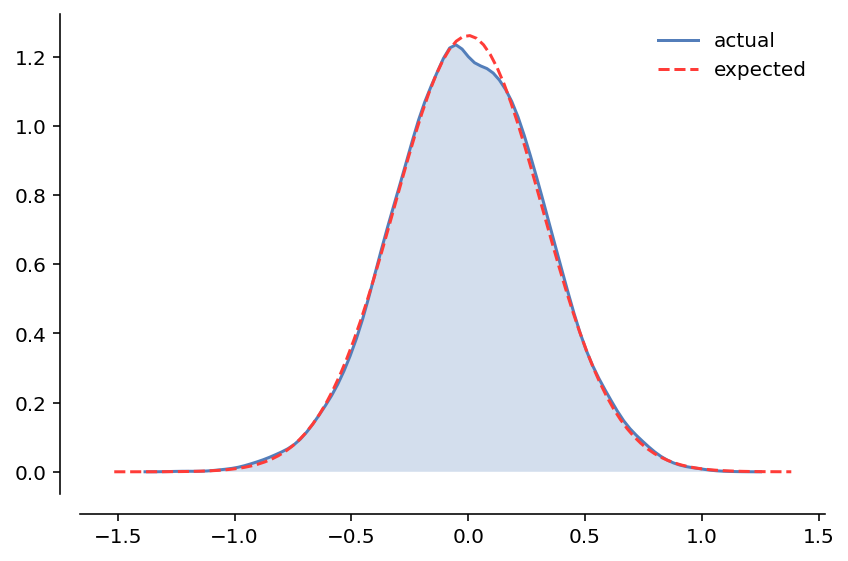

In [3]:
with FigureManager() as (_, ax):
    sns.kdeplot(np.asarray(rnd_test.weights).ravel(), ax=ax, shade=True, label="actual")

    crt_x = np.linspace(*ax.get_xlim(), 100)
    crt_sigma = 1 / np.sqrt(rnd_test.n_features)
    crt_y = (
        1
        / np.sqrt(2 * np.pi * crt_sigma ** 2)
        * np.exp(-0.5 * (crt_x / crt_sigma) ** 2)
    )
    ax.plot(crt_x, crt_y, "--", label="expected")

    ax.legend(frameon=False)

## Test with scalar output

In [4]:
rng = np.random.default_rng(1)
scalar_out = SimpleNamespace(n_features=8, n_components=1, n_samples=10000, sigma=0.7)
scalar_out.v = rng.normal(size=scalar_out.n_features)
scalar_out.x0 = np.outer(rng.normal(size=scalar_out.n_samples), scalar_out.v)
scalar_out.noise = scalar_out.sigma * rng.normal(
    size=(scalar_out.n_samples, scalar_out.n_features)
)
scalar_out.x = scalar_out.x0 + scalar_out.noise

scalar_out.circuit = NonRecurrent(
    n_features=scalar_out.n_features, n_components=scalar_out.n_components, rng=rng
)
monitor = AttributeMonitor(["weights_", "lateral_", "output_"])
scalar_out.circuit.fit(scalar_out.x, monitor=monitor, progress=tqdm)
scalar_out.history = monitor.history_

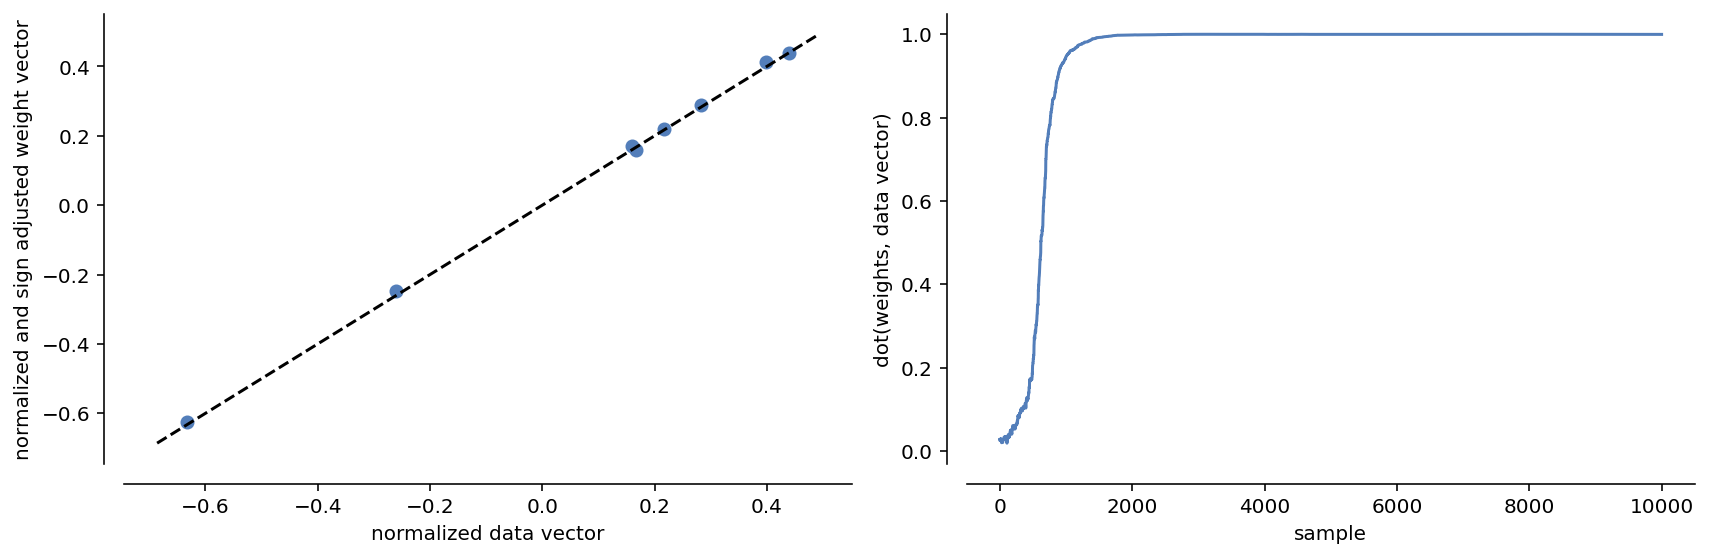

In [5]:
with FigureManager(1, 2) as (_, axs):
    norm_vec = lambda v: v / np.linalg.norm(v)
    crt_norm_inferred = norm_vec(scalar_out.circuit.weights_.flat)
    crt_norm_v = norm_vec(scalar_out.v)
    crt_norm_inferred *= np.sign(np.dot(crt_norm_v, crt_norm_inferred))
    axs[0].scatter(crt_norm_v, crt_norm_inferred)
    axs[0].plot(axs[0].get_xlim(), axs[0].get_xlim(), "k--")
    
    axs[0].set_xlabel("normalized data vector")
    axs[0].set_ylabel("normalized and sign adjusted weight vector")
    
    crt_alignment = np.zeros(scalar_out.n_samples)
    for i in range(scalar_out.n_samples):
        crt_norm_inferred = norm_vec(scalar_out.history.weights_[i, 0, :])
        crt_alignment[i] = np.dot(crt_norm_inferred, crt_norm_v)
    
    axs[1].plot(crt_alignment)
    axs[1].set_xlabel("sample")
    axs[1].set_ylabel("dot(weights, data vector)")

## Test with multiple outputs

In [6]:
rng = np.random.default_rng(2)
multi_out = SimpleNamespace(
    n_features=10,
    n_samples=100_000,
    # sigma=0.05,
    scales=[1.00, 0.75, 0.50],
    lbd=[1.00, 0.85, 0.70],
    rate=lambda t: 10 / (250 + t),
)
multi_out.n_components = len(multi_out.scales)
multi_out.rot = special_ortho_group(multi_out.n_features, seed=rng).rvs(1)
multi_out.scales_all = np.hstack(
    (multi_out.scales, (multi_out.n_features - multi_out.n_components) * [0.20])
)
multi_out.x_cov = multi_out.rot @ np.diag(multi_out.scales_all) @ multi_out.rot.T
multi_out.x = rng.multivariate_normal(
    mean=np.zeros(multi_out.n_features), cov=multi_out.x_cov, size=multi_out.n_samples
)

multi_out.circuit = NonRecurrent(
    n_features=multi_out.n_features,
    n_components=multi_out.n_components,
    learning_rate=multi_out.rate,
    scalings=multi_out.lbd,
    rng=rng,
)
monitor = AttributeMonitor(["weights_", "lateral_", "output_"])
multi_out.circuit.fit(multi_out.x, monitor=monitor, progress=tqdm)
multi_out.history = monitor.history_

multi_out.x_svd = np.linalg.svd(multi_out.x, full_matrices=False)
multi_out.uk = multi_out.x_svd[2][: multi_out.n_components].T

In [7]:
def get_dist2_procrustes(a: np.ndarray, b: np.ndarray) -> Tuple[float, np.ndarray]:
    """ Solve the orthogonal Procrustes problem.
    
    Find `r` s.t.
    
        r = argmin_q(frobenius_norm(a @ q - b)), with orthogonal q.
    
    Returns (min_frobenius, r).
    """
    m = a.T @ b
    u, s, vh = np.linalg.svd(m)
    r = u @ vh
    m = np.linalg.norm(a @ r - b, ord="fro") ** 2
    
    return m, r

In [8]:
def get_uk_from_w_and_m(w: np.ndarray, m: np.ndarray, lbdv: np.ndarray) -> np.ndarray:
    mdv = np.diag(m)
    imd = np.diag(1 / mdv)
    mo = m - np.diag(mdv)
    scaling = imd - imd @ mo @ imd
    ilbd = np.linalg.inv(np.diag(lbdv))
    return (ilbd @ scaling @ w).T

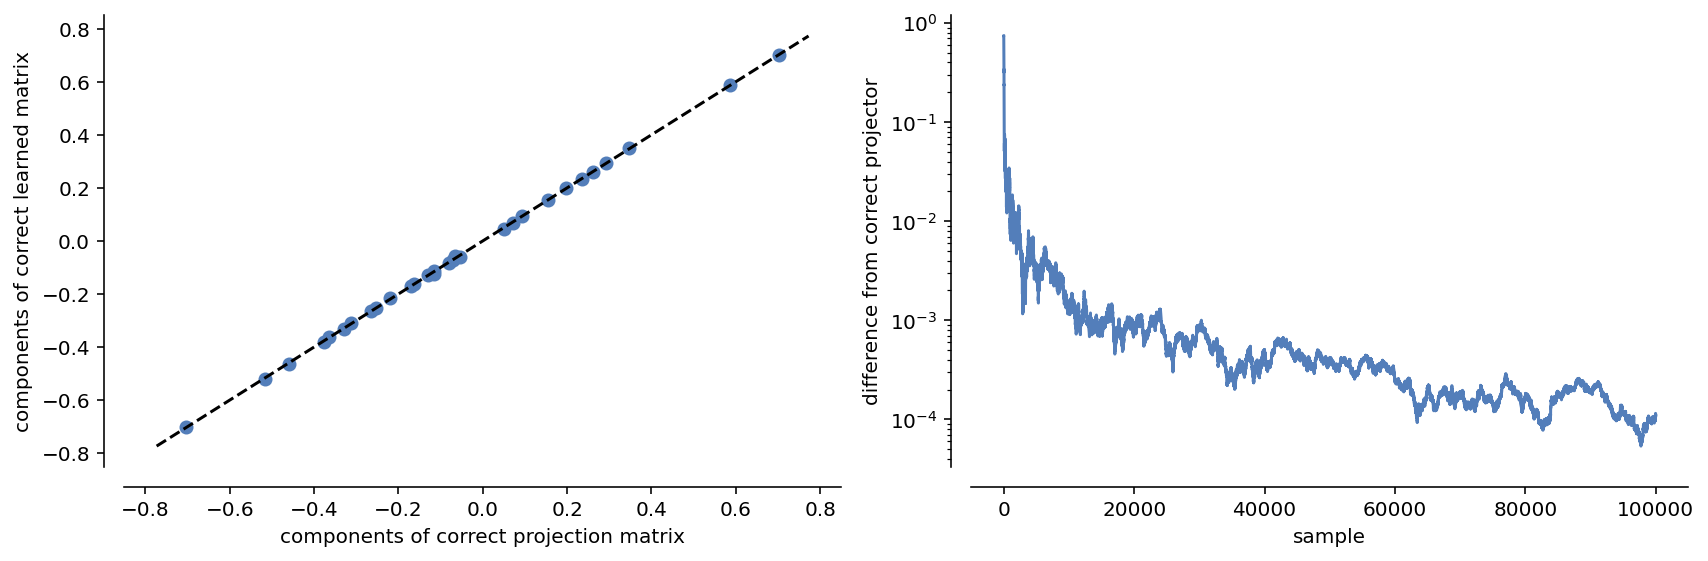

In [9]:
with FigureManager(1, 2) as (_, axs):
    crt_uk_exp = multi_out.uk
    crt_uk_exp_norm2 = np.linalg.norm(crt_uk_exp, ord="fro") ** 2
    crt_uk = get_uk_from_w_and_m(
        multi_out.circuit.weights_, multi_out.circuit.lateral_, multi_out.lbd
    )
    crt_r = get_dist2_procrustes(crt_uk, crt_uk_exp)[1]
    axs[0].scatter(crt_uk_exp.flat, (crt_uk @ crt_r).flat)
    axs[0].plot(axs[0].get_xlim(), axs[0].get_xlim(), "k--")
    axs[0].set_xlabel("components of correct projection matrix")
    axs[0].set_ylabel("components of correct learned matrix")

    crt_diffs = np.zeros(multi_out.n_samples)
    for i in tqdm(range(multi_out.n_samples)):
        crt_w = multi_out.history.weights_[i, :, :]
        crt_m = multi_out.history.lateral_[i, :, :]
        crt_uk = get_uk_from_w_and_m(crt_w, crt_m, multi_out.lbd)
        crt_diffs[i] = get_dist2_procrustes(crt_uk, crt_uk_exp)[0] / crt_uk_exp_norm2

    axs[1].plot(crt_diffs)
    axs[1].set_xlabel("sample")
    axs[1].set_ylabel("difference from correct projector")
    
    axs[1].set_yscale("log")

## Benchmark `NonRecurrent` speed

In [10]:
def benchmark_nonrecurrent(
    non_recurrent_factory: Callable[[], NonRecurrent],
    n_features: int,
    n_components: int,
    sample_sizes: Sequence,
    progress: Callable = None,
    n_rep: int = 3,
    rng: Union[int, np.random.Generator] = 0,
):
    """ Benchmark speed of `nsm.NonRecurrent`.
    
    This runs `NonRecurrent.fit` for different sample sizes, benchmarking the
    execution speed.
    
    Parameters
    ----------
    non_recurrent_factory
        Factory function for similarity-matching circuits to benchmark. Keyword
        arguments should get passed to `NonRecurrent` constructor.
    sample_sizes
        Sequence indicating which sample sizes to use.
    progress
        Callable to track progress.
    n_rep
        Number of times to repeat the time measurement. The first time,
        `timeit`s `autorange` is used to determine a good number of
        iterations, then `repeat` is called with `n_rep - 1` repeats
        and `number` set to the count returned by `autorange`.
    
    Returns a tuple of arrays, `(sample_sizes, times)`, with the first
    element, `sample_sizes`, simply a clone of the input argument, and the
    second element, `times`, indicating the times (in seconds) it took to
    transform each of the data sets with sizes given by `sample_sizes`. The
    timings are obtained by potentially running the task many times, using
    the `autorange` member from `timeit.Timer`.
    """
    times = np.zeros(len(sample_sizes))
    if progress is None:
        progress = lambda it: it

    rng = np.random.default_rng(rng)
    for i, n in enumerate(progress(sample_sizes)):
        crt_x = rng.normal(size=(n, n_features))
        timer = timeit.Timer(
            lambda: non_recurrent_factory(
                n_features=n_features, n_components=n_components
            ).fit(crt_x)
        )
        count, total_time = timer.autorange()

        other_times = timer.repeat(n_rep - 1, count)
        best_time = min(total_time, np.min(other_times))

        times[i] = best_time / count

    return sample_sizes, times

In [11]:
spd_params = SimpleNamespace(
    param_dict={
        "psp": {},
        "psw": {"whiten": True, "lateral": 0.3 * np.eye(3), "tau": 1.0},
        "npsp": {"non_negative": True},
        "npsw": {
            "non_negative": True,
            "whiten": True,
            "lateral": 0.3 * np.eye(3),
            "tau": 1.0,
        },
    },
    n_features=10,
    n_components=3,
    sample_sizes=np.geomspace(10, 100000, 10).astype(int),
)

spd_results = {}
spd_all_modes = NonRecurrent._available_modes
for crt_mode in tqdm(spd_all_modes, desc="mode"):
    for crt_params_name, crt_params in tqdm(
        spd_params.param_dict.items(), desc="type"
    ):

        def crt_factory(mode=crt_mode, **kwargs):
            circuit = NonRecurrent(**crt_params, **kwargs)
            circuit._mode = mode
            return circuit

        crt_sizes, crt_times = benchmark_nonrecurrent(
            crt_factory,
            n_features=spd_params.n_features,
            n_components=spd_params.n_components,
            sample_sizes=spd_params.sample_sizes,
            progress=tqdm,
        )

        spd_results[crt_mode, crt_params_name] = {
            "sizes": crt_sizes,
            "times": crt_times,
        }

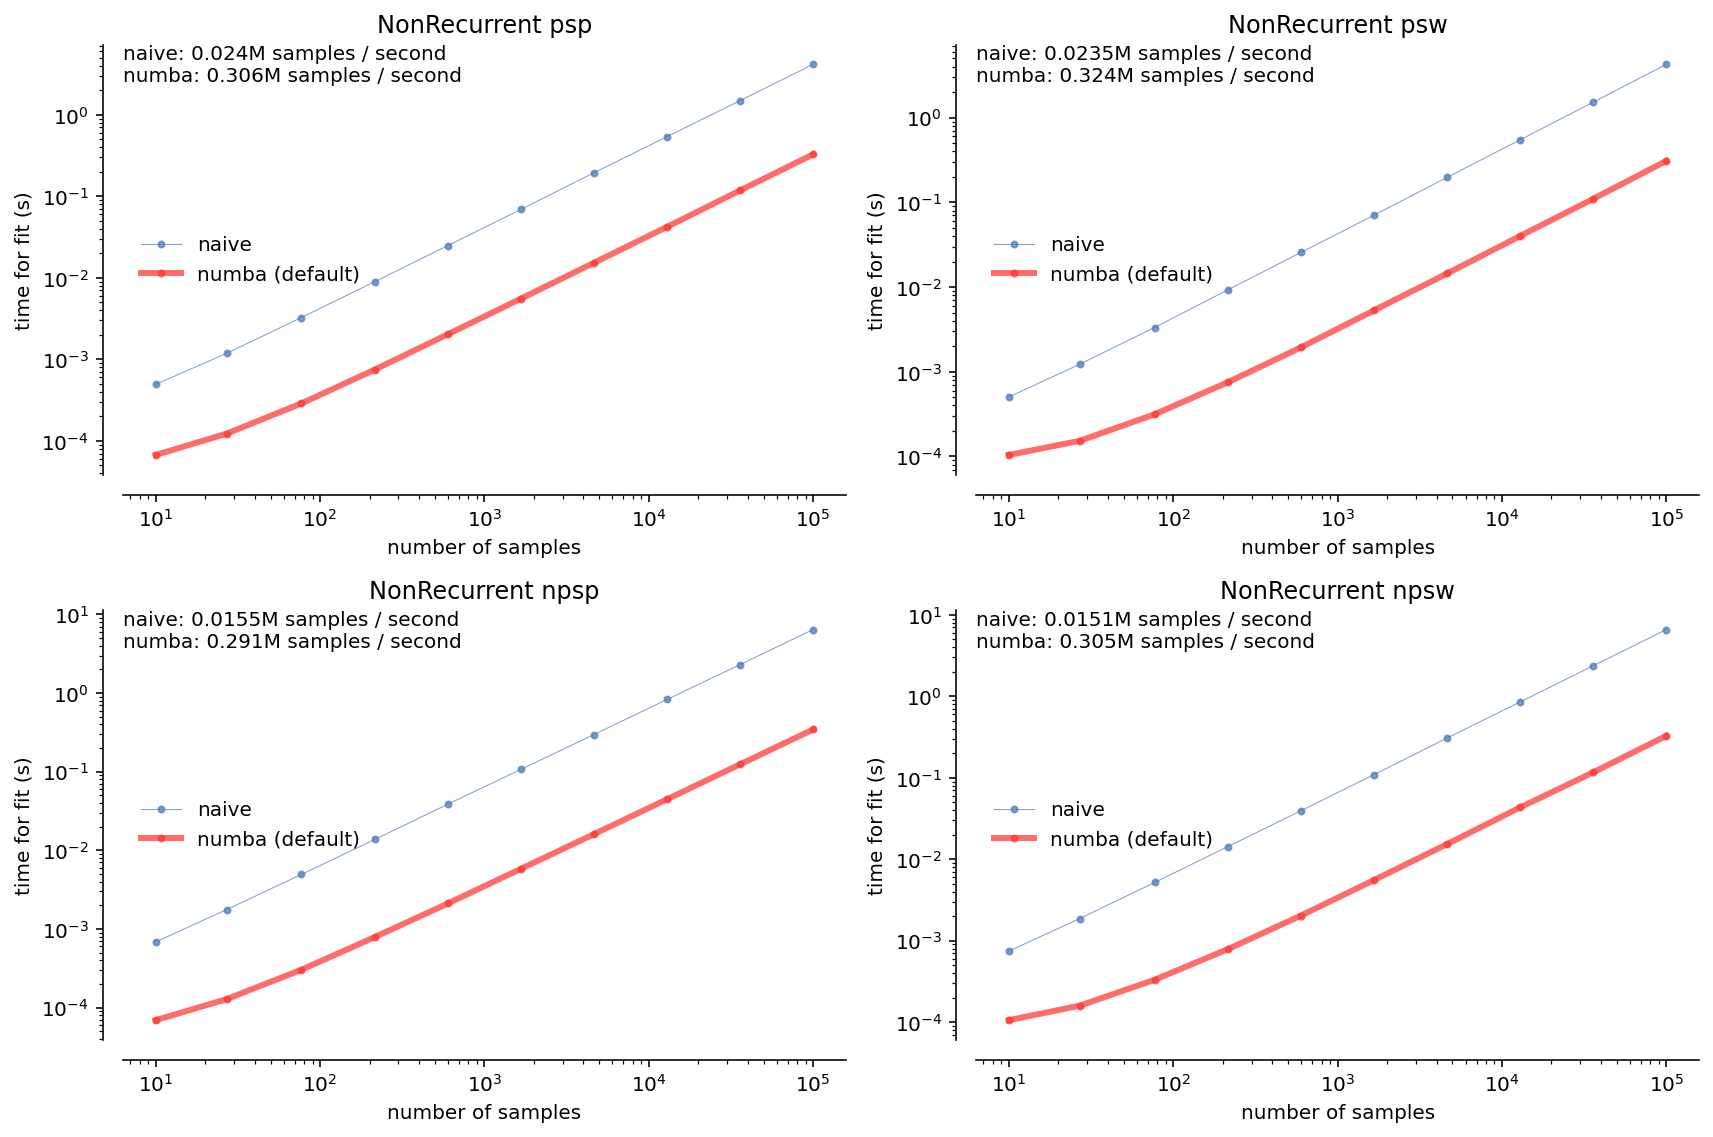

In [12]:
default_mode = NonRecurrent(3, 3)._mode

n_rows = int(np.ceil(np.sqrt(len(spd_params.param_dict))))
n_cols = int(np.ceil(len(spd_params.param_dict) / n_rows))
with FigureManager(n_rows, n_cols) as (_, axs):
    for i, ax in enumerate(axs.flat):
        crt_rates = []
        crt_annot_list = []
        for crt_mode in spd_all_modes:
            crt_params_name = list(spd_params.param_dict.keys())[i]
            crt_results = spd_results[crt_mode, crt_params_name]
            is_default = crt_mode == default_mode

            if not is_default:
                crt_label = crt_mode
            else:
                crt_label = crt_mode + " (default)"

            ax.loglog(
                crt_results["sizes"],
                crt_results["times"],
                ".-",
                label=crt_label,
                alpha=0.75,
                lw=3 if is_default else 0.5,
            )

            crt_rate = crt_results["sizes"][-1] / crt_results["times"][-1] / 1000000
            crt_rates.append(crt_rate)
            crt_annot_list.append(f"{crt_mode}: {crt_rate:.3g}M samples / second")

        ax.set_title(f"NonRecurrent {crt_params_name}")
        ax.legend(frameon=False, loc="center left")

        ax.set_xlabel("number of samples")
        ax.set_ylabel("time for fit (s)")

        crt_annot = "\n".join(crt_annot_list)
        ax.annotate(
            crt_annot, (0.0, 1.0), xycoords="axes fraction", verticalalignment="top"
        )